<a href="https://www.kaggle.com/code/neloybarman018/interpretable-fish-image-recognizer?scriptVersionId=159488967" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!nvidia-smi

Thu Jan 18 15:34:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
!pip install grad-cam fastai fastbook nbdev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 25.1 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 47.0 MB/s eta 0:00:00
  Obtaining dependency information for nbdev from https://files.pythonhosted.org/packages/45/44/2148be2391edd62b8c88c2114f380141b72276901a53d590be9f769a68e4/nbdev-2.3.13-py3-none-any.whl.metadata
  Obtaining dependency information for ghapi>=1.0.3 from https://files.pythonhosted.org/packages/60/71/064560201c434c22c9f395878ba0f21f9ede8169e61c1a109f26a377bd5e/ghapi-1.0.4-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.1/66.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 5.3 MB/s eta 0:00:00
  Created wheel for grad-cam: filename=

In [4]:
import cv2
import torch
import warnings
from fastai import *
from fastbook import *
from fastai.vision.all import *
warnings.filterwarnings('ignore')
from torchvision import transforms
from torchvision.io import read_image

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
%cd /kaggle/input/bengali-fish-images-dataset/fish_images

/kaggle/input/bengali-fish-images-dataset/fish_images


In [6]:
data_block = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    splitter = RandomSplitter(valid_pct=0.2, seed = 42),
    get_items = get_image_files,
    get_y = parent_label,
    item_tfms=Resize(224),
    batch_tfms = aug_transforms()
)

In [7]:
batch_size = 32

In [8]:
data_path = "/kaggle/input/bengali-fish-images-dataset/fish_images"

In [9]:
data_loader = data_block.dataloaders(data_path, bs=batch_size)

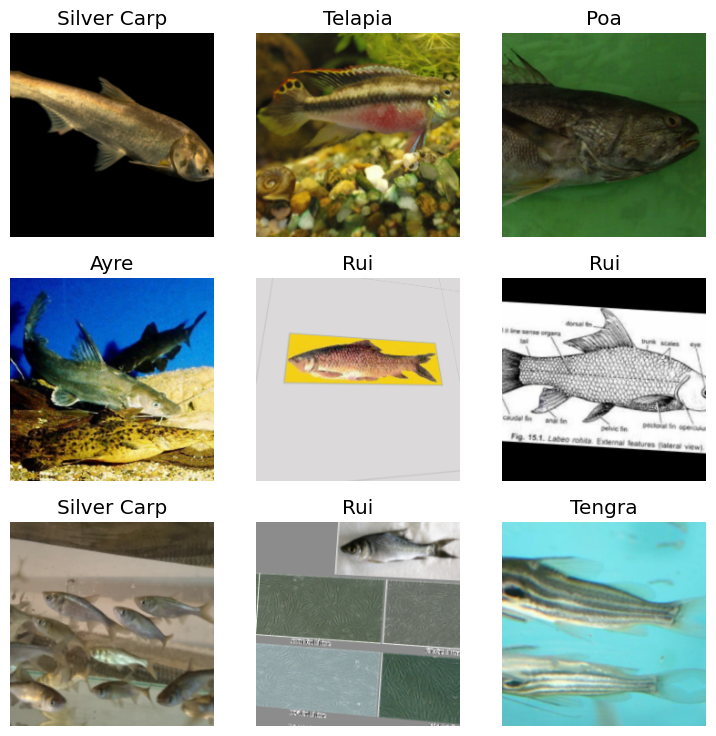

In [10]:
data_loader.train.show_batch()

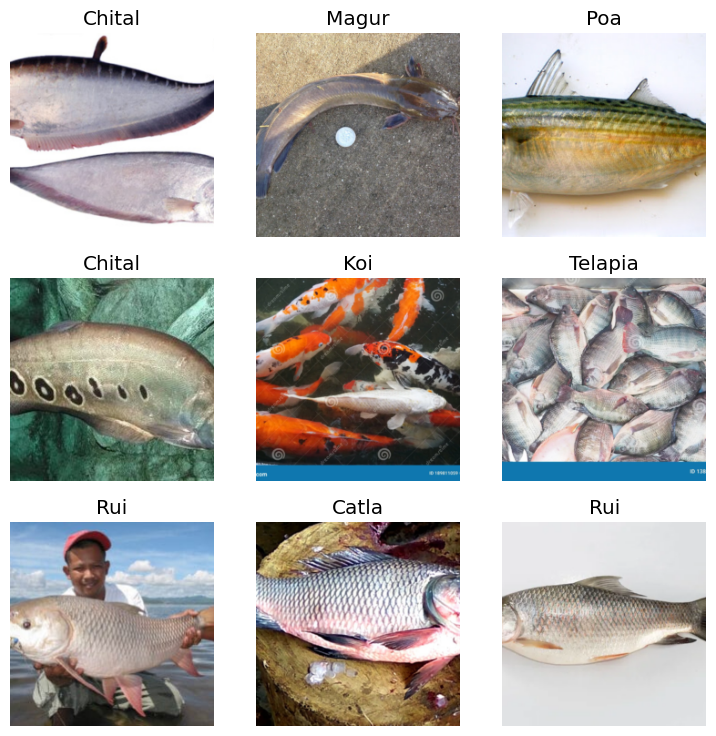

In [11]:
data_loader.valid.show_batch()

In [12]:
model = vision_learner(data_loader, resnet50, metrics = [error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 249MB/s]


In [13]:
model.freeze()

In [14]:
# model.fine_tune(30)